## Quiz #0503

### "Data Augmentation"

#### Answer the following questions by providing Python code:
#### Objectives:
- Code the helper functions.
- Optimize and test a predictive model of your choice.
- Carry out data aumentation in order to improve the predictive accuracy when the given training data is small.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics, preprocessing
from scipy.ndimage.interpolation import rotate
warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

#### Read in data:
The explanation on the original data can be found [here](http://yann.lecun.com/exdb/mnist/).

- The data we will be using is a small subset of the original data with only 100 observations.
- Each observation is the "flattened" version of a image.
- The first column corresponds to the label (Y).
- The image size is 28x28.

In [2]:
# Read the training and testing data separately.
data_train = pd.read_csv('data/data_mnist_train_100.csv', header=None,encoding='latin1')
data_test = pd.read_csv('data/data_mnist_test_100.csv', header=None,encoding='latin1')

# Scale and split the data set into X and Y.
X_train = np.array((data_train.iloc[:,1:]/255.0)*0.99+0.01)
X_test = np.array((data_test.iloc[:,1:]/255.0)*0.99+0.01)
Y_train = np.array(data_train.iloc[:,0])
Y_test = np.array(data_test.iloc[:,0])

In [5]:
X_train.shape

(100, 784)

1). Code the helper function 'show_data()' that visualizes each given observation. HINT: use matplotlib.pyplot.imshow() and scipy.ndimage.interpolation().

In [169]:
def show_data(X, Y, n, angle=0):
       # <Your code goes in here>
       im = []
       for x in range(28):
              im.append(X_train[n][x*28:28*(x+1)])
       
       im = 1.0-np.array(im)

       im = rotate(im, angle, mode="reflect", reshape=[28, 28])
       
       border = int((im.shape[0] - 28)/2)
       im = im[border: 28+border, border:28+border]

       plt.imshow(im, cmap="gray")

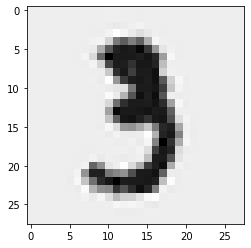

In [170]:
# Example 1.
show_data(X_train, Y_train,10,+10)

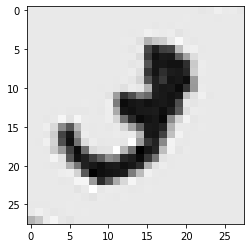

In [171]:
# Example 2.
show_data(X_train, Y_train,10,-30)

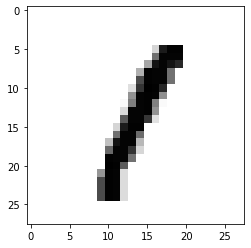

In [172]:
# Example 3.
show_data(X_train, Y_train,77,0)

2). Choose an algorithm and carry out the predictive analysis.

- Optimize the hyperparameter(s).
- Calculate the accuracy.
- Is the accuracy high enough?

In [82]:
# Classification by AdaBoost.
ABC = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10), n_estimators=100, learning_rate=0.01, random_state=123)
ABC.fit(X_train, Y_train)

Y_pred = ABC.predict(X_test)
print( "AdaBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

AdaBoost accuracy : 0.59


In [98]:
parameters = {"max_depth": range(4,20), "min_samples_split": range(2, 5), "min_samples_leaf": range(1, 5), "bootstrap": [True, False]}
gridCV = GridSearchCV(estimator=RandomForestClassifier(random_state=123, n_jobs=-1), param_grid=parameters)

gridCV.fit(X_train, Y_train)

Y_pred = gridCV.predict(X_test)
print( "AdaBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))
print("Best Parameters: ", gridCV.best_params_)

AdaBoost accuracy : 0.7
Best Parameters:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [99]:
parameters = {"n_neighbors": range(30), "metric": ["euclidean", "minkowski", "cosine"]}
gridCV = GridSearchCV(estimator=KNeighborsClassifier(), cv=10, param_grid=parameters)

# KNN = KNeighborsClassifier(n_neighbors=30, metric="euclidean")
gridCV.fit(X_train, Y_train)

Y_pred = gridCV.predict(X_test)
print( "AdaBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))
print("Best parameters:", gridCV.best_params_)

AdaBoost accuracy : 0.74
Best parameters: {'metric': 'cosine', 'n_neighbors': 1}


Note: KNN yielded relatively better results after performing a several attempts with other classification algorithms.

3). Code the helper function 'rotate_data()' that rotates each given observation by an angle. HINT: use scipy.ndimage.interpolation().

In [205]:
# <Your code goes in here>
def rotate_data(X_train, n, angle):
       im = []

       for x in range(28):
              im.append(X_train[n][x*28:28*(x+1)])

       im = rotate(np.array(im), angle, reshape=[28, 28])
       
       border = int((im.shape[0] - 28)/2)
       im = im[border: 28+border, border:28+border]

       # im = 1.0-np.array(im)
       # plt.imshow(im, cmap="gray")
       return im.reshape((784,1))[:, 0]

4). Augment the training dataset.
- Increase the size of the training dataset by introducing slight rotations (clockwise and counterclockwise).
- Use the 'rotate_data()' function defined in the previous step.
- No need to augment the testing dataset.
- Target approximately five fold augmentation.

In [219]:
# <Your code goes in here>
import random
new_data = []
new_Y = []
for i in range(400):
    direction = random.choice([-1, 1])
    index = random.randrange(len(X_train))
    angle = random.randint(0,360)

    new_image = rotate_data(X_train, index, direction*angle)
    
    new_data.append(new_image)
    
    new_Y.append(Y_train[index])

new_X_train = np.append(X_train, new_data, axis=0)
new_Y_train = np.append(Y_train, new_Y, axis=0)
new_X_train.shape, new_Y_train.shape

((500, 784), (500,))

5). Redo the predictive analysis with the augmented training dataset.

- Use the same algorithm as in the step 2).
- Calculate the accuracy.
- Has the accuracy gone up?

In [224]:
parameters = {"n_neighbors": range(30)}
gridCV = GridSearchCV(estimator=KNeighborsClassifier(), cv=10, param_grid=parameters)

# KNN = KNeighborsClassifier(n_neighbors=30, metric="euclidean")
gridCV.fit(new_X_train, new_Y_train)

Y_pred = gridCV.predict(X_test)
print( "AdaBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))
print("Best parameters:", gridCV.best_params_)

AdaBoost accuracy : 0.69
Best parameters: {'n_neighbors': 1}


In [225]:
parameters = {"max_depth": range(4,20), "min_samples_split": range(2, 5), "min_samples_leaf": range(1, 5), "bootstrap": [True, False]}
gridCV = GridSearchCV(estimator=RandomForestClassifier(random_state=123, n_jobs=-1), param_grid=parameters)

gridCV.fit(new_X_train, new_Y_train)

Y_pred = gridCV.predict(X_test)
print( "AdaBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))
print("Best Parameters: ", gridCV.best_params_)

AdaBoost accuracy : 0.72
Best Parameters:  {'bootstrap': False, 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3}


The accuracy hasn't gone up, after augmenting the dataset by adding new transformed images.